In [55]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from darts import TimeSeries
from darts.utils.data import tabularization as tab
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from darts.metrics import mape, r2_score, rmse
from darts.models import RegressionModel

import utils

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

# Model Selection

In [57]:
ts_lags = list(range(-12, 0))

# lags_past_covariates = {
#     "US_CPI": list(range(-3, 0)),
#     "US_PERSONAL_SPENDING_PCE": list(range(-3, 0)),
#     "SNP_500": list(range(-3, 0)),
#     "NEWS_SENTIMENT": list(range(-3, 0)),
#     "FFED": list(range(-3, 0)),
#     "US_UNEMPLOYMENT_RATE": list(range(-3, 0)),
# }
lags_past_covariates = {covar: list(range(-3, 0)) for covar in covariates_scaled.components}


X_train, y_train, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=train_ts_scaled,
    past_covariates=train_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_train = X_train.squeeze()
y_train = y_train.squeeze()


X_test, y_test, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=val_ts_scaled,
    past_covariates=val_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=ts_lags,
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [58]:
features_cols_names, label_cols_names = tab.create_lagged_component_names(
    ts_scaled, covariates_scaled, lags=ts_lags, lags_past_covariates=lags_past_covariates, concatenate=False
)

X_train = pd.DataFrame(X_train, columns=features_cols_names)
y_train = pd.DataFrame(y_train, columns=label_cols_names)

X_test = pd.DataFrame(X_test, columns=features_cols_names)
y_test = pd.DataFrame(y_test, columns=label_cols_names)
X_test.head()

,US_TB_YIELD_10YRS_target_lag-12,US_TB_YIELD_10YRS_target_lag-11,US_TB_YIELD_10YRS_target_lag-10,US_TB_YIELD_10YRS_target_lag-9,US_TB_YIELD_10YRS_target_lag-8,US_TB_YIELD_10YRS_target_lag-7,US_TB_YIELD_10YRS_target_lag-6,US_TB_YIELD_10YRS_target_lag-5,US_TB_YIELD_10YRS_target_lag-4,US_TB_YIELD_10YRS_target_lag-3,...,STICKCPIM157SFRBATL_pastcov_lag-1,US_PERSONAL_SPENDING_PCE_pastcov_lag-1,US_TB_YIELD_3MTHS_pastcov_lag-1,US_TB_YIELD_5YRS_pastcov_lag-1,US_TB_YIELD_3YRS_pastcov_lag-1,US_TB_YIELD_2YRS_pastcov_lag-1,US_TB_YIELD_1YR_pastcov_lag-1,FFED_pastcov_lag-1,TOTBKCR_pastcov_lag-1,US_CPI_pastcov_lag-1
0,-0.474715,-0.960974,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,...,-0.024912,-0.115604,0.252044,1.090817,0.767880,0.579284,0.330914,0.280893,-0.638487,-0.367032
1,-0.960974,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,...,0.338079,-0.057690,0.084341,-0.087879,-0.009970,0.056587,-0.064569,0.259019,-0.285073,-0.302790
2,0.400932,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,...,-0.267210,0.741807,0.085048,-0.007594,0.013730,0.018064,0.018093,0.031204,0.328547,-0.199997
3,-0.233351,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,-0.153189,...,-1.423986,0.204503,0.771748,0.360958,0.335648,0.314131,0.469124,0.281935,-0.138625,0.026050
4,0.044717,-0.489915,-0.417751,0.213808,0.284084,0.481045,1.279380,1.188898,-0.153189,-0.002843,...,0.625644,-0.018863,0.255859,-0.514260,-0.351515,-0.149695,0.102902,0.258984,-0.186849,0.303969


In [62]:
timeseries_crossval = TimeSeriesSplit(n_splits=10)
model = linear_model.LassoCV(cv=timeseries_crossval, n_alphas=50)
# model = linear_model.Lasso(alpha=0.2)
sfs = SequentialFeatureSelector(
    model, k_features=(1, 10), scoring="neg_mean_squared_error", forward=True, floating=True, cv=timeseries_crossval
)
selected_features = sfs.fit(X_train, y_train)

In [63]:
selected_features.k_feature_names_

('US_TB_YIELD_10YRS_target_lag-12',
 'US_TB_YIELD_10YRS_target_lag-10',
 'US_TB_YIELD_10YRS_target_lag-1',
 'FFED_pastcov_lag-3',
 'MICH_pastcov_lag-1',
 'US_TB_YIELD_5YRS_pastcov_lag-1')

In [ ]:
# This is not good:
# model.fit(sfs.transform(X_train), y_train)

# pred = model.predict(sfs.transform(X_test))



# diff = y_test - pred
# mse = diff.pow(2).mean()

In [29]:
y_test

,US_TB_YIELD_10YRS_target_hrz0
0,-0.002843
1,0.247482
2,-0.562939
3,0.062146
4,-0.341441
...,...
74,-0.624166
75,0.414196
76,0.613628
77,0.538035


In [ ]:

for t_i in len(pred):
    pred = TimeSeries.from_times_and_values(values=pred[], times=times[0])
    pred = utils.unscale_series(pred, pipeline, ts_scaled)

array([-0.01473924,  0.06790191, -0.15216452, -0.21921512, -0.07747688,
        0.02533735,  0.02619668, -0.08206862, -0.04228629, -0.13802102,
       -0.17238583, -0.24590299,  0.02095371, -0.02312398, -0.16917302,
        0.0181969 , -0.07651311, -0.06570107, -0.15084435, -0.03726072,
       -0.07924065, -0.10578866, -0.07139715, -0.04453404, -0.12748954,
       -0.19351302, -0.09270258, -0.07003603, -0.0274259 , -0.06482221,
        0.00444403, -0.0355275 , -0.08547832, -0.13689905,  0.05508751,
        0.02256601,  0.05168817, -0.03036887, -0.05408638, -0.1602586 ,
       -0.11414818,  0.16874379,  0.10902476,  0.3750418 , -0.20914978,
       -0.18031071, -0.0759705 , -0.00600364, -0.06276037,  0.00489654,
        0.21998236,  0.00643824,  0.03755055, -0.14968556, -0.10081311,
       -0.08775744, -0.13241148, -0.09147473,  0.03797165, -0.09922101,
       -0.10990062, -0.05714612, -0.26063108, -0.1082051 ,  0.04522433,
       -0.08840959,  0.02860495, -0.1633383 , -0.16921158, -0.14

In [31]:
# Get the model coefficients
model.coef_, sfs.k_feature_names_

(array([-0.11666735, -0.05720395, -0.        ,  0.08245573], dtype=float32),
 ('US_TB_YIELD_10YRS_target_lag-12',
  'US_TB_YIELD_10YRS_target_lag-5',
  'W068RCQ027SBEA_pastcov_lag-1',
  'STICKCPIM157SFRBATL_pastcov_lag-1'))

In [32]:
selected_features.subsets_

{1: {'feature_idx': (62,),
  'cv_scores': array([-1.64273381, -0.60000414, -0.55968726, -0.59257394, -0.56523776,
         -0.66223955, -0.36270472, -0.78095019, -0.50452995, -0.28121203]),
  'avg_score': -0.6551873356103897,
  'feature_names': ('W068RCQ027SBEA_pastcov_lag-1',)},
 2: {'feature_idx': (0, 62),
  'cv_scores': array([-1.65252781, -0.61872482, -0.54199016, -0.5504058 , -0.54075187,
         -0.65599614, -0.35905996, -0.82609576, -0.51740938, -0.25738308]),
  'avg_score': -0.652034479379654,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-12',
   'W068RCQ027SBEA_pastcov_lag-1')},
 3: {'feature_idx': (0, 62, 68),
  'cv_scores': array([-1.65252781, -0.60000414, -0.54928279, -0.55186558, -0.52168941,
         -0.6579861 , -0.36044475, -0.82844031, -0.51808161, -0.25725776]),
  'avg_score': -0.6497580260038376,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-12',
   'W068RCQ027SBEA_pastcov_lag-1',
   'STICKCPIM157SFRBATL_pastcov_lag-1')},
 4: {'feature_idx': (0, 7, 62, 68),


In [17]:
pred = pred.squeeze()
pred = TimeSeries.from_times_and_values(values=pred, times=times[0])
pred = utils.unscale_series(pred, pipeline, ts_scaled)


y_test = TimeSeries.from_times_and_values(values=y_test["US_TB_YIELD_10YRS_target_hrz0"], times=times[0])
y_test = utils.unscale_series(y_test, pipeline, ts_scaled)

<Axes: xlabel='DATE'>

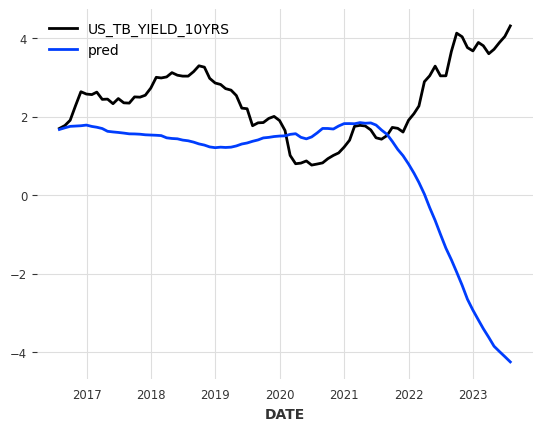

In [18]:
# pd.Series(pred.squeeze()).plot(label="pred")
# ts.drop_before(pd.Timestamp("2015/12/31")).plot()
y_test.plot()
pred.plot(label="pred")

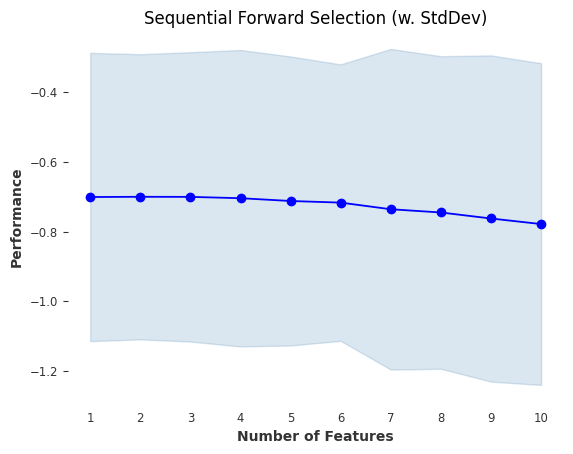

In [17]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_dev")

# plt.ylim([0.8, 1])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()

In [18]:
def plot_features(features: list[str]):
    features.append("FFED_diff")
    px.line(df, x=df.index, y=features).show()

In [19]:
plot_features(['US_CPI_EXCL_FOOD_N_ENERGY_diff',
   'CANADA_CPI_diff',
   'US_TB_YIELD_1YR_diff'])

ValueError: All arguments should have the same length. The length of argument `y` is 4, whereas the length of  previously-processed arguments ['DATE'] is 524

In [ ]:
px.line(df, x=df.index, y=["FFED_diff", ]).show()